In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


In [2]:
# Example usage:
# This was the previous run
#animals = ['PV_62', 'PV_126', 'PV_57']
#block_lists = [[24, 26, 38], [7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
#This with new animals:
animals = ['PV_126' ]
block_lists = [[7]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    #load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

    for block in block_collection:
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_corr_angles.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_corr_angles.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_xflipped.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_xflipped.csv')
        block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_3d_corr_verified.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_3d_corr_verified.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_rotated_verified.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_rotated_verified.csv')

    # calibrate pupil diameter:
    # if 'pupil_diameter' not in block.left_eye_data.columns:
    #     block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    #     block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    #     block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    #     block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!
running parse_open_ephys_events...
block 007 has a parsed events file, reading...
Getting eye brightness values for block 007...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [3]:
for block in block_collection:
  if 'pupil_diameter' not in block.left_eye_data.columns:
        print(f'calculating pupil diameter for {block} ')
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

calculating pupil diameter for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 


In [4]:
block.left_eye_data.columns

Index(['Unnamed: 0', 'OE_timestamp', 'eye_frame', 'ms_axis', 'center_x',
       'center_y', 'phi', 'width', 'height', 'major_ax', 'minor_ax', 'ratio',
       'ratio2', 'phi_ellipse', 'k_phi', 'k_theta', 'pupil_diameter_pixels',
       'pupil_diameter'],
      dtype='object')

In [5]:
# # uncomment to switch corrected values to k_phi / theta columns
# for block in block_collection:
#     block.left_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     block.right_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     # then rename in-place
#     block.left_eye_data = block.left_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})
#     block.right_eye_data = block.right_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})

In [6]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [7]:

for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.left_eye_data,
        0.6,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=100,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.right_eye_data,
        0.6,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=100,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


In [8]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\Animal=PV_126,recNames=block_007\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


In [9]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [10]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [11]:
len(saccade_collection)

2948

In [12]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


1468it [00:00, 6711.52it/s]


438 1353


In [13]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [14]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [16]:
import matplotlib.pyplot as plt
# Reset to default settings
plt.rcdefaults()
import numpy as np
import pandas as pd
from scipy.signal import medfilt
import datetime
import pathlib
from matplotlib.ticker import MultipleLocator
# make pdf compatible
from matplotlib import rc
rc('pdf', fonttype=42)
from matplotlib import rcParams
# Font settings for consistency
rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})

def plot_zoomed_in(start_time, end_time, traces=None, left_df=None, right_df=None, left_ms=None, right_ms=None,
                   head_movements_ms=None, state_df=None, figure_size=(15, 6), window_size=10000,
                   bin_size=1000, export_path=None, std_multiplier=4):
    """
    Plot zoomed-in eye movement data with options to display state annotations and head movements.
    This version plots the angular (phi and theta) traces (from k_phi and k_theta columns) instead of
    the original center_x/center_y values, and automatically defines the y-axis limits around the median
    value ± (std_multiplier * std) of the data (computed over the zoom window). This preserves extreme values
    while zooming in on the main dynamics.

    Args:
        start_time (float): Start time in seconds for the zoomed-in region.
        end_time (float): End time in seconds for the zoomed-in region.
        traces (list, optional): List of data traces to plot. Available options:
                                 ['center_x', 'center_y', 'pupil_diameter', 'saccade_frequency'].
                                 Here, 'center_x' plots phi (from k_phi) and 'center_y' plots theta (from k_theta).
        left_df (pd.DataFrame, required): Left eye data containing columns
                                          ['k_phi', 'k_theta', 'pupil_diameter', 'ms_axis'].
        right_df (pd.DataFrame, required): Right eye data containing columns
                                           ['k_phi', 'k_theta', 'pupil_diameter', 'ms_axis'].
        left_ms (array-like, required): Array of left eye saccade onset times in milliseconds.
        right_ms (array-like, required): Array of right eye saccade onset times in milliseconds.
        head_movements_ms (list, optional): List of head movement timestamps in milliseconds.
        state_df (pd.DataFrame, optional): DataFrame containing 'start_time', 'end_time', 'annotation'
                                           (e.g., 'stationary', 'explores') for state annotations.
        figure_size (tuple, optional): Size of the figure. Defaults to (15, 6).
        window_size (int, optional): Rolling window size for saccade frequency calculation in milliseconds.
                                     Defaults to 10000.
        bin_size (int, optional): Bin size for saccade frequency calculation in milliseconds. Defaults to 1000.
        export_path (str, optional): File path to export the figure as a PDF.
        std_multiplier (float, optional): Multiplier for the standard deviation to set y-axis limits
                                          around the median value. Defaults to 4.
    """

    # Convert ms_axis to seconds for the x-axis
    x_axis = left_df.ms_axis / 1000

    # Filter data within the specified time window
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x_axis = x_axis[mask]

    # Saccade rate calculation remains unchanged
    def calculate_saccade_rate(left_ms, right_ms, window_size=10000, bin_size=1000):
        all_saccades = np.sort(np.unique(np.concatenate((left_ms, right_ms))))
        time_bins = np.arange(start_time * 1000, end_time * 1000 + bin_size, bin_size)
        saccade_count = np.zeros_like(time_bins, dtype=float)
        for i in range(len(time_bins)):
            start_time_bin = time_bins[i] - window_size
            end_time_bin = time_bins[i]
            saccade_count[i] = np.sum((all_saccades >= start_time_bin) & (all_saccades <= end_time_bin))
        # Convert to rate (saccades per second)
        saccade_rate = saccade_count / (window_size / 1000)
        return time_bins, saccade_rate

    time_bins, saccade_rate = calculate_saccade_rate(left_ms, right_ms, window_size, bin_size)
    saccade_mask = (time_bins / 1000 >= start_time) & (time_bins / 1000 <= end_time)
    zoomed_time_bins = time_bins[saccade_mask] / 1000
    zoomed_saccade_rate = saccade_rate[saccade_mask]

    # Initialize the plot
    num_traces = len(traces) if traces else 0
    fig, axes = plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, np.ndarray):
        axes = [axes]  # Ensure axes is iterable

    for i, trace in enumerate(traces):
        if trace == 'center_x':
            # Get the data for phi (k_phi) from left and right eyes
            data_phi = np.concatenate([left_df['k_phi'][mask].values, right_df['k_phi'][mask].values])
            med_val = np.nanmedian(data_phi)
            std_val = np.nanstd(data_phi)
            if not (np.isnan(med_val) or np.isnan(std_val)):
                y_low = med_val - std_multiplier * std_val
                y_high = med_val + std_multiplier * std_val
                axes[i].set_ylim(y_low, y_high)
            # Plot the traces
            axes[i].plot(zoomed_x_axis, left_df['k_phi'][mask], label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, right_df['k_phi'][mask], label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Phi (deg)')

        elif trace == 'center_y':
            # Get the data for theta (k_theta) from left and right eyes
            data_theta = np.concatenate([left_df['k_theta'][mask].values, right_df['k_theta'][mask].values])
            med_val = np.nanmedian(data_theta)
            std_val = np.nanstd(data_theta)
            if not (np.isnan(med_val) or np.isnan(std_val)):
                y_low = med_val - std_multiplier * std_val
                y_high = med_val + std_multiplier * std_val
                axes[i].set_ylim(y_low, y_high)
            # Plot the traces
            axes[i].plot(zoomed_x_axis, left_df['k_theta'][mask], label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, right_df['k_theta'][mask], label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Theta (deg)')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            # Process pupil diameter using a median filter for smoothing
            left_pupil = medfilt(left_df['pupil_diameter'], 121)[mask]
            right_pupil = medfilt(right_df['pupil_diameter'], 121)[mask]
            data_pupil = np.concatenate([left_pupil, right_pupil])
            med_val = np.nanmedian(data_pupil)
            std_val = np.nanstd(data_pupil)
            if not (np.isnan(med_val) or np.isnan(std_val)):
                y_low = med_val - std_multiplier * std_val
                y_high = med_val + std_multiplier * std_val
                axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x_axis, left_pupil, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, right_pupil, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'saccade_frequency':
            axes[i].plot(zoomed_time_bins, zoomed_saccade_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccade Rate (Hz)')
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            axes[i].set_xlim(left=start_time, right=end_time)

        # Add common xlabel for the last subplot
        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')

    # Add vertical lines for head movements, if provided
    if head_movements_ms is not None:
        for ts in head_movements_ms:
            if start_time <= ts / 1000 <= end_time:
                axes[0].axvline(x=ts / 1000, color='red', linestyle='--', linewidth=1)

    # Plot state annotations, positioning lines at the top (stationary) or bottom (explores) of the y-axis
    if state_df is not None:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                state_start = max(row['start_time'], start_time)
                state_end = min(row['end_time'], end_time)
                ylims = axes[0].get_ylim()
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=ylims[1], xmin=state_start, xmax=state_end, color='red', linewidth=3)
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=ylims[0], xmin=state_start, xmax=state_end, color='green', linewidth=3)

    # Minimalistic adjustments: let Matplotlib set tick locations automatically.
    for ax in axes:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # Add a legend for the traces in the first subplot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.75, 0.23))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

    if export_path is not None:
        print(f'exporting to {export_path}')
        plt.savefig(export_path, format='pdf')
    plt.show()


In [17]:
import matplotlib.pyplot as plt
# Reset to default settings
plt.rcdefaults()
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from matplotlib import rc
from matplotlib import rcParams

# Make PDF compatible and set font styles
rc('pdf', fonttype=42)
rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})

def plot_zoomed_in_autofit_data(start_time, end_time, traces=None, left_df=None, right_df=None, left_ms=None, right_ms=None,
                   head_movements_ms=None, state_df=None, figure_size=(15, 6), window_size=10000,
                   bin_size=1000, export_path=None, limit_margins=1):
    """
    Plot zoomed-in eye movement data with options to display state annotations and head movements.
    This version plots the angular (phi and theta) traces (from k_phi and k_theta columns) instead of
    the original center_x/center_y values, and automatically defines the y-axis limits to fully include
    the trace data within the zoom window.
    """

    # Convert ms_axis to seconds for the x-axis
    x_axis = left_df.ms_axis / 1000
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x_axis = x_axis[mask]

    def calculate_saccade_rate(left_ms, right_ms, window_size=10000, bin_size=1000):
        all_saccades = np.sort(np.unique(np.concatenate((left_ms, right_ms))))
        time_bins = np.arange(start_time * 1000, end_time * 1000 + bin_size, bin_size)
        saccade_count = np.zeros_like(time_bins, dtype=float)
        for i in range(len(time_bins)):
            start_time_bin = time_bins[i] - window_size
            end_time_bin = time_bins[i]
            saccade_count[i] = np.sum((all_saccades >= start_time_bin) & (all_saccades <= end_time_bin))
        saccade_rate = saccade_count / (window_size / 1000)
        return time_bins, saccade_rate

    time_bins, saccade_rate = calculate_saccade_rate(left_ms, right_ms, window_size, bin_size)
    saccade_mask = (time_bins / 1000 >= start_time) & (time_bins / 1000 <= end_time)
    zoomed_time_bins = time_bins[saccade_mask] / 1000
    zoomed_saccade_rate = saccade_rate[saccade_mask]

    num_traces = len(traces) if traces else 0
    fig, axes = plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for i, trace in enumerate(traces):
        if trace == 'center_x':
            phi_left = left_df['k_phi'][mask].values
            phi_right = right_df['k_phi'][mask].values
            data_phi = np.concatenate([phi_left, phi_right])
            y_low, y_high = np.nanmin(data_phi) - limit_margins, np.nanmax(data_phi) + limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x_axis, phi_left, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, phi_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Phi (deg)')

        elif trace == 'center_y':
            theta_left = left_df['k_theta'][mask].values
            theta_right = right_df['k_theta'][mask].values
            data_theta = np.concatenate([theta_left, theta_right])
            y_low, y_high = np.nanmin(data_theta) - limit_margins, np.nanmax(data_theta)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x_axis, theta_left, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, theta_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Theta (deg)')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            left_pupil = medfilt(left_df['pupil_diameter'], 121)[mask]
            right_pupil = medfilt(right_df['pupil_diameter'], 121)[mask]
            data_pupil = np.concatenate([left_pupil, right_pupil])
            y_low, y_high = np.nanmin(data_pupil) - limit_margins, np.nanmax(data_pupil)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x_axis, left_pupil, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, right_pupil, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'saccade_frequency':
            axes[i].plot(zoomed_time_bins, zoomed_saccade_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccade Rate (Hz)')
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            axes[i].set_xlim(left=start_time, right=end_time)

        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')

    if head_movements_ms is not None:
        for ts in head_movements_ms:
            if start_time <= ts / 1000 <= end_time:
                axes[0].axvline(x=ts / 1000, color='red', linestyle='--', linewidth=1)

    if state_df is not None:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                state_start = max(row['start_time'], start_time)
                state_end = min(row['end_time'], end_time)
                ylims = axes[0].get_ylim()
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=ylims[1], xmin=state_start, xmax=state_end, color='red', linewidth=3)
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=ylims[0], xmin=state_start, xmax=state_end, color='green', linewidth=3)

    for ax in axes:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.75, 0.23))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

    if export_path is not None:
        print(f'exporting to {export_path}')
        plt.savefig(export_path, format='pdf')
    plt.show()


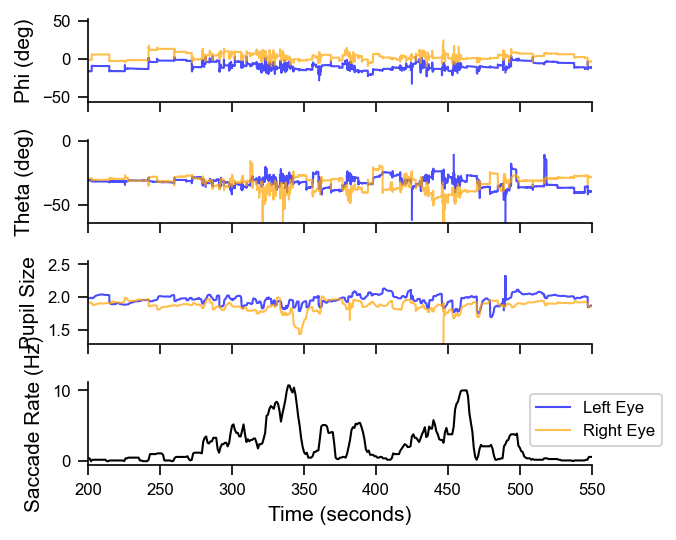

In [18]:
# Example usage (adjust export_path and data as needed):
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_deg\{t}_eye_movement_trace_pv_62_b7_thr4_05.pdf'
plot_zoomed_in(start_time=200, end_time=550,
               traces=['center_x', 'center_y', 'pupil_diameter', 'saccade_frequency'],
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None,
               state_df=None,
               figure_size=(4.7, 3.7),
               export_path=None,
               std_multiplier=7)


In [29]:
def plot_zoomed_in_with_headmov_annotations(
    start_time, end_time,
    traces=None,
    left_df=None, right_df=None,
    left_ms=None, right_ms=None,
    head_movements_ms=None,
    state_df=None,
    figure_size=(15, 6),
    window_size=10000,
    bin_size=1000,
    export_path=None,
    std_multiplier=4,
    limit_margins=1,
    l_saccade_df=None,   # OPTIONAL: if provided, will use get_head_mov_col-style overlap logic
    r_saccade_df=None    # OPTIONAL
):
    """
    Same plotting behavior as plot_zoomed_in(), plus head-movement annotations:
    - Grey thin vlines at raw head movement times within the window (if head_movements_ms is provided).
    - Thick colored vlines at saccade onsets whose [on, off] intervals overlap a head movement, in the spirit of
      get_head_mov_col() (requires l_saccade_df and r_saccade_df + head_movements_ms).

    Notes:
    - Does not mutate l_saccade_df / r_saccade_df.
    - If l_saccade_df / r_saccade_df are None, only raw movement lines are shown (backward compatible).
    """

    import numpy as _np
    import pandas as _pd
    import matplotlib.pyplot as _plt
    from scipy.signal import medfilt as _medfilt

    # --- helpers ---
    def _calc_saccade_rate(left_ms, right_ms, start_time, end_time, window_size=10000, bin_size=1000):
        all_saccades = _np.sort(_np.unique(_np.concatenate((left_ms, right_ms))))
        time_bins = _np.arange(start_time * 1000, end_time * 1000 + bin_size, bin_size)
        saccade_count = _np.zeros_like(time_bins, dtype=float)
        for i in range(len(time_bins)):
            st = time_bins[i] - window_size
            en = time_bins[i]
            saccade_count[i] = _np.sum((all_saccades >= st) & (all_saccades <= en))
        return time_bins, saccade_count / (window_size / 1000)  # Hz

    def _label_head_movement_segments(saccade_df, mov_times_ms):
        """
        Vectorized-ish overlap: head_movement=True if any mov time in [on_ms, off_ms].
        Returns a shallow copy with a boolean 'head_movement' column.
        """
        if saccade_df is None or len(saccade_df) == 0:
            return None
        out = saccade_df.copy()
        out['head_movement'] = False

        if mov_times_ms is None or len(mov_times_ms) == 0:
            return out

        mov = _np.asarray(mov_times_ms)
        # Ensure we only handle rows that have both on/off
        valid = out[['saccade_on_ms', 'saccade_off_ms']].dropna().index
        # Simple loop (fast enough for typical sizes; avoids nested Python loops on mov)
        for idx in valid:
            on = out.at[idx, 'saccade_on_ms']
            off = out.at[idx, 'saccade_off_ms']
            # quick mask check
            if _np.any((mov >= on) & (mov <= off)):
                out.at[idx, 'head_movement'] = True
        return out

    # --- data & masks ---
    x_axis = left_df.ms_axis / 1000.0
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x = x_axis[mask]

    # saccade rate
    time_bins, sacc_rate = _calc_saccade_rate(left_ms, right_ms, start_time, end_time, window_size, bin_size)
    s_mask = (time_bins / 1000.0 >= start_time) & (time_bins / 1000.0 <= end_time)
    z_time_bins = time_bins[s_mask] / 1000.0
    z_sacc_rate = sacc_rate[s_mask]

    # --- figure/axes ---
    num_traces = len(traces) if traces else 0
    fig, axes = _plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, _np.ndarray):
        axes = [axes]

    # --- draw traces with auto y-limits behavior (two modes) ---
    for i, trace in enumerate(traces):
        if trace == 'center_x':
            # phi
            phi_left = left_df['k_phi'].values[mask]
            phi_right = right_df['k_phi'].values[mask]
            data_phi = _np.concatenate([phi_left, phi_right])
            # auto-fit around median ± std_multiplier*std if std_multiplier provided; else full span with margins
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_phi)
                std_val = _np.nanstd(data_phi)
                if not (_np.isnan(med_val) or _np.isnan(std_val)):
                    y_low, y_high = med_val - std_multiplier * std_val, med_val + std_multiplier * std_val
                else:
                    y_low, y_high = _np.nanmin(data_phi) - limit_margins, _np.nanmax(data_phi) + limit_margins
            else:
                y_low, y_high = _np.nanmin(data_phi) - limit_margins, _np.nanmax(data_phi) + limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, phi_left, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, phi_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Phi (deg)')

        elif trace == 'center_y':
            # theta
            th_left = right_df['k_theta'].values if right_df is not None else None  # guard for mislabels
            theta_left = left_df['k_theta'].values[mask]
            theta_right = right_df['k_theta'].values[mask]
            data_theta = _np.concatenate([theta_left, theta_right])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_theta)
                std_val = _np.nanstd(data_theta)
                if not (_np.isnan(med_val) or _np.isnan(std_val)):
                    y_low, y_high = med_val - std_multiplier * std_val, med_val + std_multiplier * std_val
                else:
                    y_low, y_high = _np.nanmin(data_theta) - limit_margins, _np.nanmax(data_theta) + limit_margins
            else:
                y_low, y_high = _np.nanmin(data_theta) - limit_margins, _np.nanmax(data_theta) + limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, theta_left, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, theta_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Theta (deg)')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            left_pupil = _medfilt(left_df['pupil_diameter'], 121)[mask]
            right_pupil = _medfilt(right_df['pupil_diameter'], 121)[mask]
            data_pupil = _np.concatenate([left_pupil, right_pupil])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_pupil)
                std_val = _np.nanstd(data_pupil)
                if not (_np.isnan(med_val) or _np.isnan(std_val)):
                    y_low, y_high = med_val - std_multiplier * std_val, med_val + std_multiplier * std_val
                else:
                    y_low, y_high = _np.nanmin(data_pupil) - limit_margins, _np.nanmax(data_pupil) + limit_margins
            else:
                y_low, y_high = _np.nanmin(data_pupil) - limit_margins, _np.nanmax(data_pupil) + limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, left_pupil, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, right_pupil, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'saccade_frequency':
            axes[i].plot(z_time_bins, z_sacc_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccade Rate (Hz)')
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            axes[i].set_xlim(left=start_time, right=end_time)

        # x label on last subplot
        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')

    # --- HEAD MOVEMENT ANNOTATIONS ---
    # 1) Context lines for raw movement timestamps in the window (thin, grey)
    if head_movements_ms is not None:
        for ts in head_movements_ms:
            ts_sec = ts / 1000.0
            if start_time <= ts_sec <= end_time:
                axes[0].axvline(x=ts_sec, color='0.7', linestyle='--', linewidth=0.8, alpha=0.8, zorder=0)

    # 2) Saccade-onset markers for saccades that overlap a head movement (requires saccade dfs)
    #    Blue for left, orange for right
    if (l_saccade_df is not None) and (r_saccade_df is not None) and (head_movements_ms is not None):
        l_lab = _label_head_movement_segments(l_saccade_df, head_movements_ms)
        r_lab = _label_head_movement_segments(r_saccade_df, head_movements_ms)

        if l_lab is not None and len(l_lab):
            sel = l_lab[(l_lab['head_movement']) & (l_lab['saccade_on_ms'].notna())]
            for ts in sel['saccade_on_ms'].values:
                ts_sec = ts / 1000.0
                if start_time <= ts_sec <= end_time:
                    axes[0].axvline(x=ts_sec, color='blue', linestyle='-', linewidth=1.6, alpha=0.85, zorder=3)

        if r_lab is not None and len(r_lab):
            sel = r_lab[(r_lab['head_movement']) & (r_lab['saccade_on_ms'].notna())]
            for ts in sel['saccade_on_ms'].values:
                ts_sec = ts / 1000.0
                if start_time <= ts_sec <= end_time:
                    axes[0].axvline(x=ts_sec, color='orange', linestyle='-', linewidth=1.6, alpha=0.85, zorder=3)

    # --- state annotations (same as your function) ---
    if state_df is not None and len(axes) > 0:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                state_start = max(row['start_time'], start_time)
                state_end = min(row['end_time'], end_time)
                ylims = axes[0].get_ylim()
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=ylims[1], xmin=state_start, xmax=state_end, color='red', linewidth=3)
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=ylims[0], xmin=state_start, xmax=state_end, color='green', linewidth=3)

    # --- cosmetics (same as your function) ---
    for ax in axes:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.75, 0.23))

    _plt.tight_layout()
    _plt.subplots_adjust(right=0.85)

    if export_path is not None:
        print(f'exporting to {export_path}')
        _plt.savefig(export_path, format='pdf')
    _plt.show()


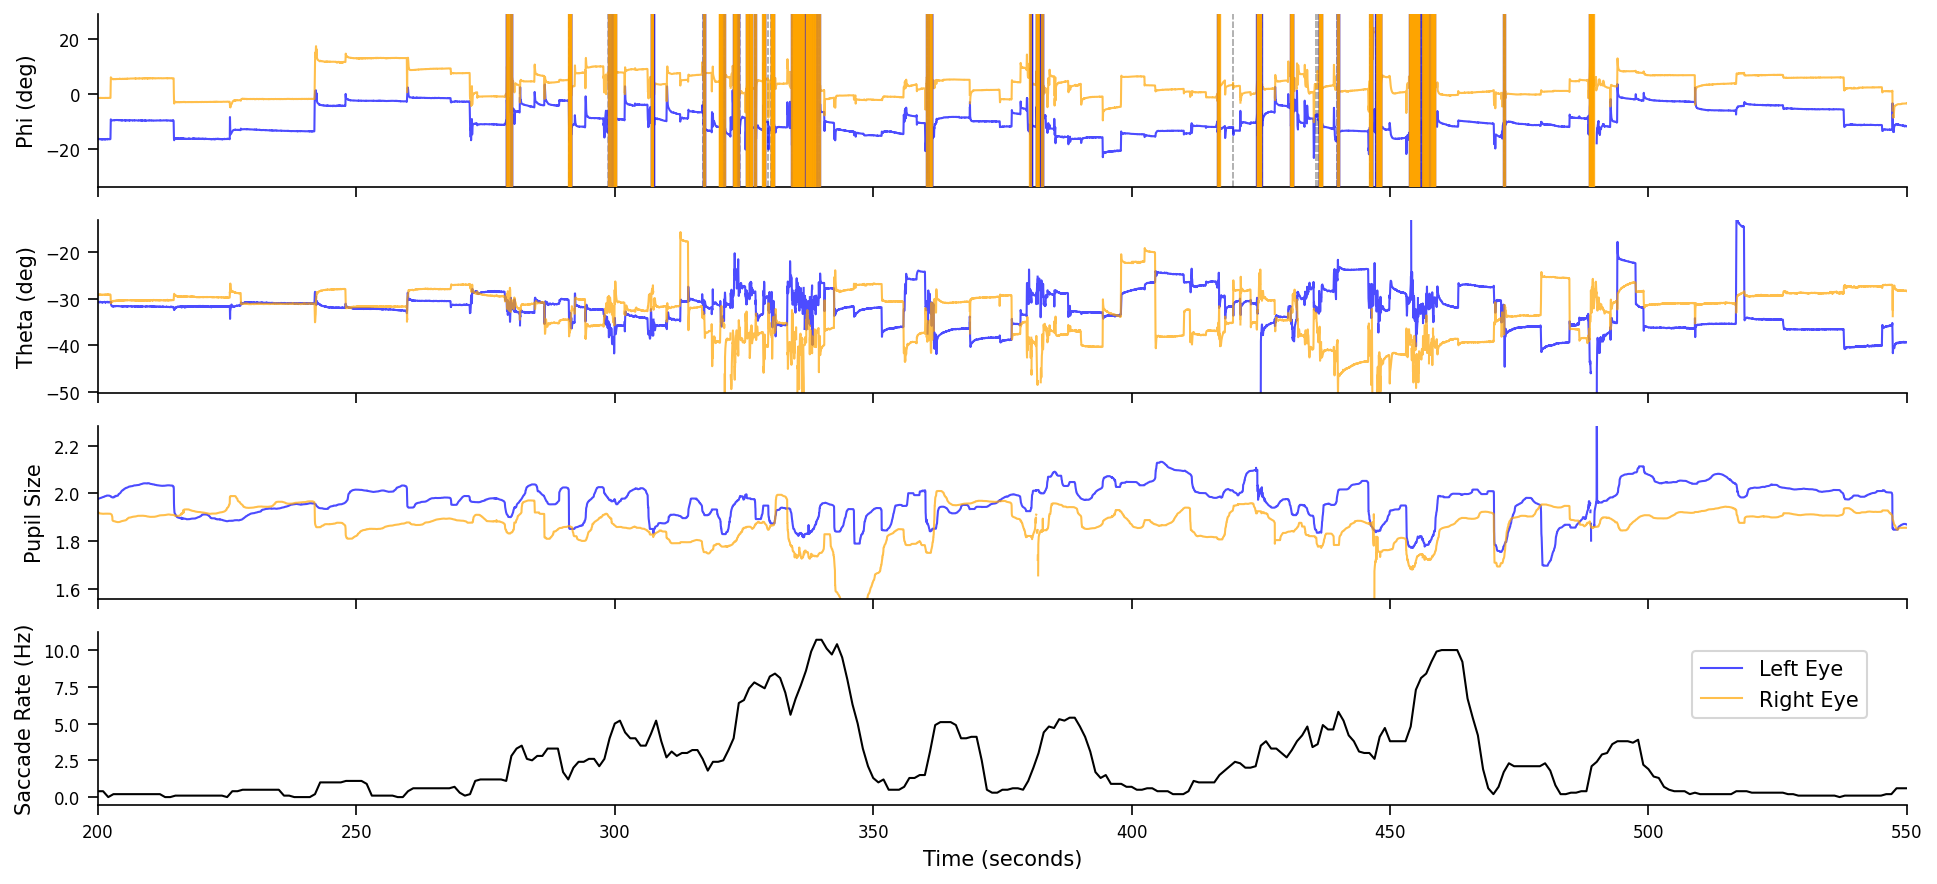

In [34]:
plot_zoomed_in_with_headmov_annotations(
    start_time=200, end_time=550,
    traces=['center_x','center_y','pupil_diameter','saccade_frequency'],
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    left_ms=block.l_saccade_df.saccade_on_ms.values,
    right_ms=block.r_saccade_df.saccade_on_ms.values,
    head_movements_ms=block.liz_mov_df.query('movAll > 0.003')['t_mov_ms'].values,
    l_saccade_df=block.l_saccade_df,      # enables get_head_mov_col-style overlap logic
    r_saccade_df=block.r_saccade_df
)


In [39]:
np.unique(np.diff(block.liz_mov_df.t_mov_ms.values))

array([4.0000e+00, 8.0000e+00, 1.2000e+01, 1.6000e+01, 2.0000e+01,
       2.4000e+01, 2.8000e+01, 3.2000e+01, 3.6000e+01, 4.0000e+01,
       4.4000e+01, 4.8000e+01, 5.2000e+01, 5.6000e+01, 6.0000e+01,
       6.4000e+01, 6.8000e+01, 7.2000e+01, 7.6000e+01, 8.0000e+01,
       8.4000e+01, 8.8000e+01, 9.2000e+01, 9.6000e+01, 1.0000e+02,
       1.0400e+02, 1.0800e+02, 1.1200e+02, 1.1600e+02, 1.2000e+02,
       1.2400e+02, 1.2800e+02, 1.3200e+02, 1.3600e+02, 1.4000e+02,
       1.4400e+02, 1.4800e+02, 1.5200e+02, 1.5600e+02, 1.6000e+02,
       1.6400e+02, 1.6800e+02, 1.7200e+02, 1.7600e+02, 1.8000e+02,
       1.8400e+02, 1.8800e+02, 1.9200e+02, 1.9600e+02, 2.0000e+02,
       2.0400e+02, 2.0800e+02, 2.1200e+02, 2.1600e+02, 2.2000e+02,
       2.2400e+02, 2.2800e+02, 2.3200e+02, 2.3600e+02, 2.4000e+02,
       2.4400e+02, 2.4800e+02, 2.5600e+02, 2.6000e+02, 2.6800e+02,
       2.7200e+02, 2.7600e+02, 2.8000e+02, 2.8400e+02, 2.8800e+02,
       2.9200e+02, 2.9600e+02, 3.0000e+02, 3.0400e+02, 3.0800e

In [17]:
def plot_zoomed_in_with_head_rate(
    start_time, end_time,
    traces=None,
    left_df=None, right_df=None,
    left_ms=None, right_ms=None,
    head_movements_ms=None,
    state_df=None,
    figure_size=(15, 6),
    window_size=10000,
    bin_size=1000,
    export_path=None,
    std_multiplier=4,
    limit_margins=1,
    l_saccade_df=None,   # kept for signature compatibility (not used here)
    r_saccade_df=None    # kept for signature compatibility (not used here)
):
    """
    Same as your zoomed plot, but instead of head-movement vlines it adds a
    head-movement rate trace (Hz) alongside the saccade rate.

    Inputs are identical to your current plot function.
    """

    import numpy as _np
    import pandas as _pd
    import matplotlib.pyplot as _plt
    from scipy.signal import medfilt as _medfilt

    # ---------- helpers ----------
    def _as_array_ms(x):
        """Safely turn None/list/array/Series into a flat float np.array in ms."""
        if x is None:
            return _np.array([], dtype=float)
        # Handle pandas Series/DataFrame columns gracefully
        try:
            arr = _np.asarray(x, dtype=float).ravel()
        except Exception:
            arr = _np.array(x, dtype=float).ravel()
        return arr

    def _calc_rate(events_ms, start_time, end_time, window_size=10000, bin_size=1000):
        """
        Generic sliding-window event rate (Hz).
        events_ms: np.array of event times in ms.
        start_time/end_time: seconds (float).
        window_size/bin_size: ms.
        Returns: (time_bins_ms, rate_hz)
        """
        # bins are in ms
        tb = _np.arange(start_time*1000.0, end_time*1000.0 + bin_size, bin_size, dtype=float)
        if events_ms.size == 0:
            return tb, _np.zeros_like(tb, dtype=float)
        # simple sliding window count
        rate = _np.zeros_like(tb, dtype=float)
        for i, t in enumerate(tb):
            st = t - window_size
            en = t
            # inclusive window as in your original code
            rate[i] = _np.sum((events_ms >= st) & (events_ms <= en))
        return tb, rate / (window_size / 1000.0)

    def _calc_saccade_rate(left_ms, right_ms, start_time, end_time, window_size=10000, bin_size=1000):
        l = _as_array_ms(left_ms)
        r = _as_array_ms(right_ms)
        all_sacc = _np.sort(_np.unique(_np.concatenate([l, r]))) if (l.size or r.size) else _np.array([], dtype=float)
        return _calc_rate(all_sacc, start_time, end_time, window_size, bin_size)

    def _calc_head_rate(head_ms, start_time, end_time, window_size=10000, bin_size=1000):
        h = _as_array_ms(head_ms)
        return _calc_rate(h, start_time, end_time, window_size, bin_size)

    # ---------- data & masks ----------
    x_axis = left_df.ms_axis / 1000.0  # seconds
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x = x_axis[mask]

    # precompute saccade rate bins/mask
    time_bins_ms, sacc_rate = _calc_saccade_rate(left_ms, right_ms, start_time, end_time, window_size, bin_size)
    z_mask = (time_bins_ms/1000.0 >= start_time) & (time_bins_ms/1000.0 <= end_time)
    z_time = (time_bins_ms[z_mask] / 1000.0)
    z_sacc_rate = sacc_rate[z_mask]

    # precompute head-movement rate with identical params
    head_bins_ms, head_rate = _calc_head_rate(head_movements_ms, start_time, end_time, window_size, bin_size)
    z_head_rate = head_rate[z_mask]  # same mask because bins are identical by construction

    # ---------- figure/axes ----------
    num_traces = len(traces) if traces else 0
    fig, axes = _plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, _np.ndarray):
        axes = [axes]

    # ---------- drawing ----------
    for i, trace in enumerate(traces or []):
        if trace == 'center_x':
            # phi
            phi_left = left_df['k_phi'].values[mask]
            phi_right = right_df['k_phi'].values[mask]
            data_phi = _np.concatenate([phi_left, phi_right])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_phi)
                std_val = _np.nanstd(data_phi)
                if _np.isfinite(med_val) and _np.isfinite(std_val):
                    y_low, y_high = med_val - std_multiplier*std_val, med_val + std_multiplier*std_val
                else:
                    y_low, y_high = _np.nanmin(data_phi)-limit_margins, _np.nanmax(data_phi)+limit_margins
            else:
                y_low, y_high = _np.nanmin(data_phi)-limit_margins, _np.nanmax(data_phi)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, phi_left,  label='Left Eye',  color='blue',   linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, phi_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Phi (deg)')

        elif trace == 'center_y':
            theta_left = left_df['k_theta'].values[mask]
            theta_right = right_df['k_theta'].values[mask]
            data_theta = _np.concatenate([theta_left, theta_right])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_theta)
                std_val = _np.nanstd(data_theta)
                if _np.isfinite(med_val) and _np.isfinite(std_val):
                    y_low, y_high = med_val - std_multiplier*std_val, med_val + std_multiplier*std_val
                else:
                    y_low, y_high = _np.nanmin(data_theta)-limit_margins, _np.nanmax(data_theta)+limit_margins
            else:
                y_low, y_high = _np.nanmin(data_theta)-limit_margins, _np.nanmax(data_theta)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, theta_left,  label='Left Eye',  color='blue',   linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, theta_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Theta (deg)')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            left_pupil  = _medfilt(left_df['pupil_diameter'],  121)[mask]
            right_pupil = _medfilt(right_df['pupil_diameter'], 121)[mask]
            data_pupil = _np.concatenate([left_pupil, right_pupil])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_pupil)
                std_val = _np.nanstd(data_pupil)
                if _np.isfinite(med_val) and _np.isfinite(std_val):
                    y_low, y_high = med_val - std_multiplier*std_val, med_val + std_multiplier*std_val
                else:
                    y_low, y_high = _np.nanmin(data_pupil)-limit_margins, _np.nanmax(data_pupil)+limit_margins
            else:
                y_low, y_high = _np.nanmin(data_pupil)-limit_margins, _np.nanmax(data_pupil)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, left_pupil,  label='Left Eye',  color='blue',   linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, right_pupil, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'saccade_frequency':
            axes[i].plot(z_time, z_sacc_rate, label='Saccade Rate',        color='black', linewidth=1.2)
            axes[i].plot(z_time, z_head_rate, label='Head Movement Rate',  color='purple', linewidth=1.2, alpha=0.9)
            axes[i].set_ylabel('Rate (Hz)')
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            axes[i].set_xlim(left=start_time, right=end_time)

        # x label on last subplot
        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')

    # ---------- state annotations (as before) ----------
    if state_df is not None and len(axes) > 0:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                state_start = max(row['start_time'], start_time)
                state_end   = min(row['end_time'],  end_time)
                ylims = axes[0].get_ylim()
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=ylims[1], xmin=state_start, xmax=state_end, color='red',   linewidth=3)
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=ylims[0], xmin=state_start, xmax=state_end, color='green', linewidth=3)

    # ---------- cosmetics ----------
    for ax in axes:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # unified legend (collect from all axes)
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h); labels.extend(l)
    if handles:
        # de-duplicate while preserving order
        seen = set()
        uniq = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]
        fig.legend([h for h, _ in uniq], [l for _, l in uniq], loc='center left', bbox_to_anchor=(0.75, 0.23))

    _plt.tight_layout()
    _plt.subplots_adjust(right=0.85)

    if export_path is not None:
        print(f'exporting to {export_path}')
        _plt.savefig(export_path, format='pdf')
    _plt.show()


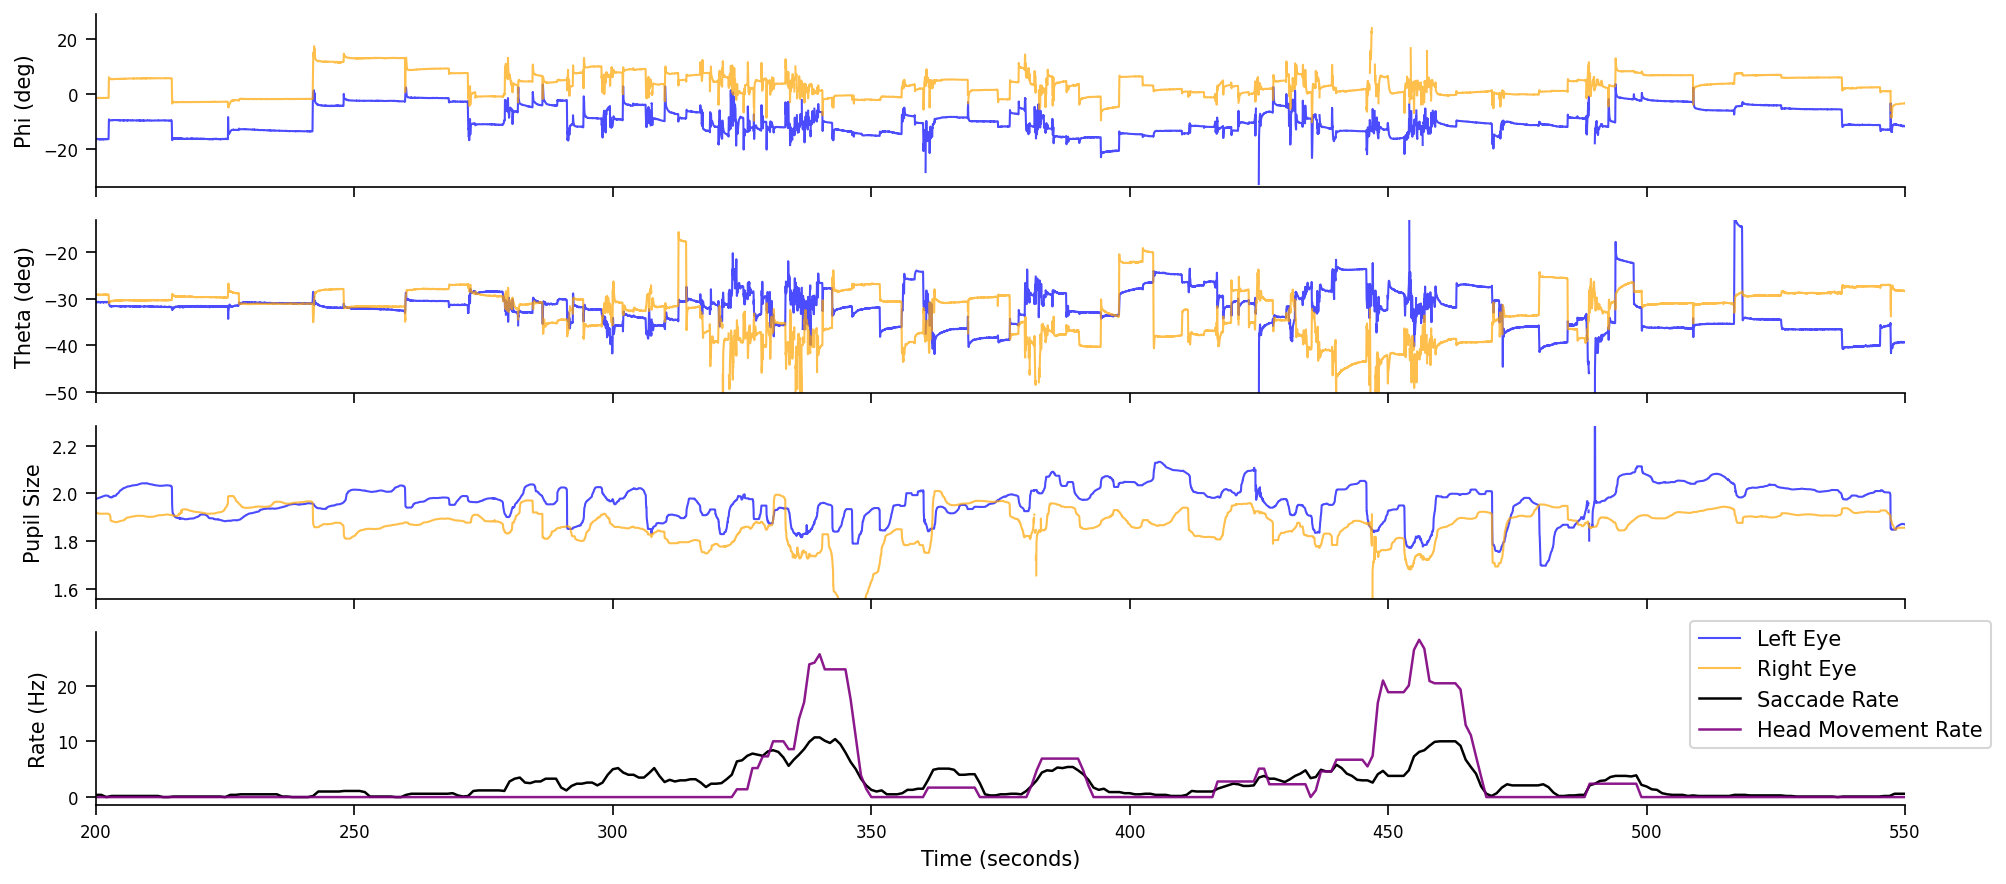

In [27]:
plot_zoomed_in_with_head_rate(
    start_time=200, end_time=550,
    traces=['center_x','center_y','pupil_diameter','saccade_frequency'],
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    left_ms=block.l_saccade_df.saccade_on_ms.values,
    right_ms=block.r_saccade_df.saccade_on_ms.values,
    head_movements_ms=block.liz_mov_df.query('movAll > 0.004')['t_mov_ms'].values,
    l_saccade_df=block.l_saccade_df,      # enables get_head_mov_col-style overlap logic
    r_saccade_df=block.r_saccade_df
)


In [23]:
len(block.liz_mov_df.query('movAll > 0.0035')['t_mov_ms'].values) == len(block.liz_mov_df)

False

In [50]:
def plot_zoomed_in_with_head_rate(
    start_time, end_time,
    traces=None,
    left_df=None, right_df=None,
    left_ms=None, right_ms=None,
    head_movements_ms=None,
    state_df=None,
    figure_size=(15, 6),
    window_size=10000,
    bin_size=1000,
    export_path=None,
    std_multiplier=4,
    limit_margins=1,
    l_saccade_df=None,   # kept for signature compatibility (not used here)
    r_saccade_df=None,   # kept for signature compatibility (not used here)
    head_merge_ms=0,     # NEW: merge adjacent head-movement events if gap < this (ms). 0 = off.
    head_merge_strategy='first'  # 'first' | 'last' | 'mean' | 'median'
):
    """
    Same as before, but head movements are plotted as a rate (Hz). Now supports
    merging adjacent head-movement events if their separation is below head_merge_ms.

    - head_merge_ms: float (ms). If > 0, collapse sequences of head-movement timestamps
      whose gaps are < head_merge_ms into a single event per sequence.
    - head_merge_strategy: representative timestamp for a merged cluster:
        'first' (default), 'last', 'mean', or 'median'.
    """

    import numpy as _np
    import pandas as _pd
    import matplotlib.pyplot as _plt
    from scipy.signal import medfilt as _medfilt

    # ---------- helpers ----------
    def _as_array_ms(x):
        """Safely turn None/list/array/Series into a flat float np.array in ms."""
        if x is None:
            return _np.array([], dtype=float)
        try:
            arr = _np.asarray(x, dtype=float).ravel()
        except Exception:
            arr = _np.array(x, dtype=float).ravel()
        # drop NaNs, sort
        arr = arr[_np.isfinite(arr)]
        return _np.sort(arr)

    def _merge_close_events(events_ms, merge_ms=0.0, strategy='first'):
        """
        Collapse adjacent events if their time gap is < merge_ms.
        Returns a 1D sorted array of merged event times (ms).
        """
        ev = _as_array_ms(events_ms)
        if ev.size == 0 or (merge_ms is None) or (merge_ms <= 0):
            return ev

        merged = []
        cluster = [ev[0]]
        for t in ev[1:]:
            if (t - cluster[-1]) < merge_ms:
                cluster.append(t)
            else:
                # finalize cluster
                if strategy == 'last':
                    merged.append(cluster[-1])
                elif strategy == 'mean':
                    merged.append(float(_np.mean(cluster)))
                elif strategy == 'median':
                    merged.append(float(_np.median(cluster)))
                else:  # 'first'
                    merged.append(cluster[0])
                cluster = [t]
        # finalize last cluster
        if cluster:
            if strategy == 'last':
                merged.append(cluster[-1])
            elif strategy == 'mean':
                merged.append(float(_np.mean(cluster)))
            elif strategy == 'median':
                merged.append(float(_np.median(cluster)))
            else:
                merged.append(cluster[0])

        return _np.asarray(merged, dtype=float)

    def _calc_rate(events_ms, start_time, end_time, window_size=10000, bin_size=1000):
        """
        Sliding-window event rate (Hz) over [start_time, end_time].
        - events_ms: np.array of event times in ms.
        - window_size/bin_size: ms.
        Returns: (time_bins_ms, rate_hz)
        """
        tb = _np.arange(start_time*1000.0, end_time*1000.0 + bin_size, bin_size, dtype=float)
        if events_ms.size == 0:
            return tb, _np.zeros_like(tb, dtype=float)
        rate = _np.zeros_like(tb, dtype=float)
        # inclusive window as in your original code
        for i, t in enumerate(tb):
            st = t - window_size
            en = t
            rate[i] = _np.sum((events_ms >= st) & (events_ms <= en))
        return tb, rate / (window_size / 1000.0)

    def _calc_saccade_rate(left_ms, right_ms, start_time, end_time, window_size=10000, bin_size=1000):
        l = _as_array_ms(left_ms)
        r = _as_array_ms(right_ms)
        all_sacc = _np.sort(_np.unique(_np.concatenate([l, r]))) if (l.size or r.size) else _np.array([], dtype=float)
        return _calc_rate(all_sacc, start_time, end_time, window_size, bin_size)

    def _calc_head_rate(head_ms, start_time, end_time, window_size=1000, bin_size=100,
                        merge_ms=0.0, strategy='first'):
        merged = _merge_close_events(head_ms, merge_ms=merge_ms, strategy=strategy)
        return _calc_rate(merged, start_time, end_time, window_size, bin_size)

    # ---------- data & masks ----------
    x_axis = left_df.ms_axis / 1000.0  # seconds
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x = x_axis[mask]

    # saccade rate (Hz)
    time_bins_ms, sacc_rate = _calc_saccade_rate(left_ms, right_ms, start_time, end_time, window_size, bin_size)
    z_mask = (time_bins_ms/1000.0 >= start_time) & (time_bins_ms/1000.0 <= end_time)
    z_time = (time_bins_ms[z_mask] / 1000.0)
    z_sacc_rate = sacc_rate[z_mask]

    # head-movement rate (Hz), with merging if requested
    head_bins_ms, head_rate = _calc_head_rate(head_movements_ms, start_time, end_time,
                                              window_size, bin_size,
                                              merge_ms=float(head_merge_ms) if head_merge_ms else 0.0,
                                              strategy=head_merge_strategy)
    # bins are built identically; reuse z_mask
    z_head_rate = head_rate[z_mask]

    # ---------- figure/axes ----------
    num_traces = len(traces) if traces else 0
    fig, axes = _plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, _np.ndarray):
        axes = [axes]

    # ---------- drawing ----------
    for i, trace in enumerate(traces or []):
        if trace == 'center_x':
            phi_left = left_df['k_phi'].values[mask]
            phi_right = right_df['k_phi'].values[mask]
            data_phi = _np.concatenate([phi_left, phi_right])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_phi)
                std_val = _np.nanstd(data_phi)
                if _np.isfinite(med_val) and _np.isfinite(std_val):
                    y_low, y_high = med_val - std_multiplier*std_val, med_val + std_multiplier*std_val
                else:
                    y_low, y_high = _np.nanmin(data_phi)-limit_margins, _np.nanmax(data_phi)+limit_margins
            else:
                y_low, y_high = _np.nanmin(data_phi)-limit_margins, _np.nanmax(data_phi)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, phi_left,  label='Left Eye',  color='blue',   linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, phi_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Phi (deg)')

        elif trace == 'center_y':
            theta_left = left_df['k_theta'].values[mask]
            theta_right = right_df['k_theta'].values[mask]
            data_theta = _np.concatenate([theta_left, theta_right])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_theta)
                std_val = _np.nanstd(data_theta)
                if _np.isfinite(med_val) and _np.isfinite(std_val):
                    y_low, y_high = med_val - std_multiplier*std_val, med_val + std_multiplier*std_val
                else:
                    y_low, y_high = _np.nanmin(data_theta)-limit_margins, _np.nanmax(data_theta)+limit_margins
            else:
                y_low, y_high = _np.nanmin(data_theta)-limit_margins, _np.nanmax(data_theta)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, theta_left,  label='Left Eye',  color='blue',   linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, theta_right, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Theta (deg)')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            left_pupil  = _medfilt(left_df['pupil_diameter'],  121)[mask]
            right_pupil = _medfilt(right_df['pupil_diameter'], 121)[mask]
            data_pupil = _np.concatenate([left_pupil, right_pupil])
            if std_multiplier is not None:
                med_val = _np.nanmedian(data_pupil)
                std_val = _np.nanstd(data_pupil)
                if _np.isfinite(med_val) and _np.isfinite(std_val):
                    y_low, y_high = med_val - std_multiplier*std_val, med_val + std_multiplier*std_val
                else:
                    y_low, y_high = _np.nanmin(data_pupil)-limit_margins, _np.nanmax(data_pupil)+limit_margins
            else:
                y_low, y_high = _np.nanmin(data_pupil)-limit_margins, _np.nanmax(data_pupil)+limit_margins
            axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x, left_pupil,  label='Left Eye',  color='blue',   linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x, right_pupil, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'saccade_frequency':
            axes[i].plot(z_time, z_sacc_rate, label='Saccade Rate',       color='black',  linewidth=1.2)
            axes[i].plot(z_time, z_head_rate, label='Head Movement Rate', color='purple', linewidth=1.2, alpha=0.9)
            axes[i].set_ylabel('Rate (Hz)')
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            axes[i].set_xlim(left=start_time, right=end_time)

        # x label on last subplot
        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')

    # ---------- state annotations (unchanged) ----------
    if state_df is not None and len(axes) > 0:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                state_start = max(row['start_time'], start_time)
                state_end   = min(row['end_time'],  end_time)
                ylims = axes[0].get_ylim()
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=ylims[1], xmin=state_start, xmax=state_end, color='red',   linewidth=3)
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=ylims[0], xmin=state_start, xmax=state_end, color='green', linewidth=3)

    # ---------- cosmetics ----------
    for ax in axes:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # unified legend (collect from all axes)
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h); labels.extend(l)
    if handles:
        seen = set()
        uniq = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]
        fig.legend([h for h, _ in uniq], [l for _, l in uniq], loc='center left', bbox_to_anchor=(0.75, 0.23))

    _plt.tight_layout()
    _plt.subplots_adjust(right=0.85)

    if export_path is not None:
        print(f'exporting to {export_path}')
        _plt.savefig(export_path, format='pdf')
    _plt.show()


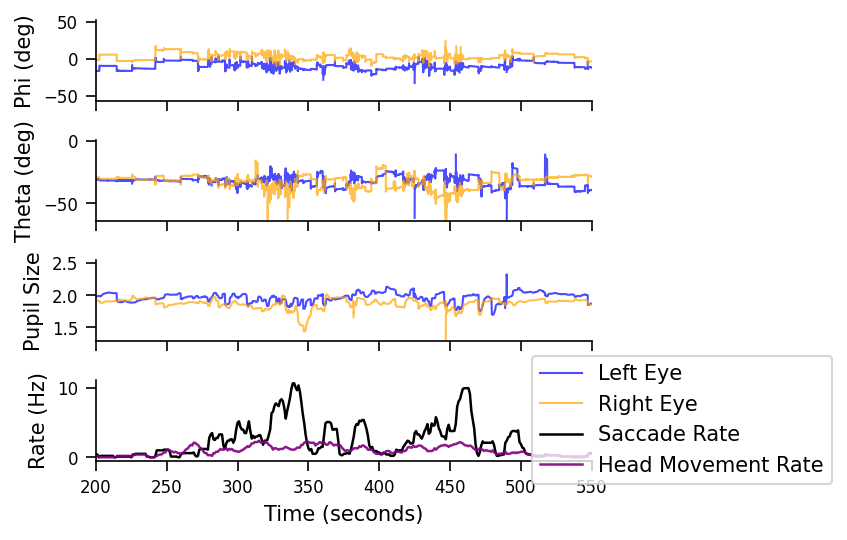

In [58]:
plot_zoomed_in_with_head_rate(
    start_time=200, end_time=550,
    traces=['center_x','center_y','pupil_diameter','saccade_frequency'],
    left_df=block.left_eye_data, right_df=block.right_eye_data,
    left_ms=block.l_saccade_df.saccade_on_ms.values,
    right_ms=block.r_saccade_df.saccade_on_ms.values,
    head_movements_ms=block.liz_mov_df.t_mov_ms.values,
    head_merge_ms=20,                 # <-- merge events closer than 150 ms
    head_merge_strategy='first',        # or 'last'/'mean'/'median'
    figure_size=(4.7, 3.7),
    export_path=None,
    std_multiplier=7)